In [1]:
import torch, sys
import numpy as np
from torch.autograd import Variable
from torchviz import make_dot
import torch.nn.functional as F
from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go

In [36]:
# generate two sets of random data:
# 1. Data from a sinusoidal curve bound within -1, 1
# 2. Data from linear curve from 0 - 100

def sinusoidal_data(x):
    return np.sin(x)**3

def linear_data(x):
    return 2*x + 5

x   = np.linspace(-5,5,1000, dtype=np.float32)
y_1 = sinusoidal_data(x[(x>=-1) & (x<=1)])
y_2 = linear_data(x[(x<=-1) | (x>=1)])

y = np.concatenate((y_1, y_2))

In [31]:
# Generic Regression Class
class Regression(torch.nn.Module):
    
    def __init__(self, input_dims, output_dims, output_activation, hidden_dims=250):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, hidden_dims)
        self.h1           = torch.nn.Linear(hidden_dims, hidden_dims)
        self.output_layer = torch.nn.Linear(hidden_dims, output_dims)
        self.output_activation = output_activation
        
    def forward(self, x):
        out = self.input_layer(x)
        out = F.relu(out)
        
        out = self.h1(out)
        out = F.relu(out)
        
        out = self.output_layer(out)
        out = self.output_activation(out) if self.output_activation != None else out
        return out

# Expert 1 has non-linerities, but is bound between -1 & 1
class Expert_1(torch.nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, 250)
        self.h1           = torch.nn.Linear(250, 250)
        self.output_layer = torch.nn.Linear(250, output_dims)
        
    def forward(self, x):
        out = self.input_layer(x)
        out = F.relu(out)
        
        out = self.h1(out)
        out = F.relu(out)
        
        out = self.output_layer(out)
        out = torch.tanh(out)
        return out

# Expert 2 can only work with linear data, but is unbound
class Expert_2(torch.nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, 25)
        self.output_layer = torch.nn.Linear(25, output_dims)
        
    def forward(self, x):
        out = self.input_layer(x)
        out = self.output_layer(out)
        return out

# Router model will return a softmax, weighing how much weight to place on each expert
class Router(torch.nn.Module):
    def __init__(self, input_dims):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, 250)
        self.h1           = torch.nn.Linear(250, 250)
        self.output_layer = torch.nn.Linear(250, 2)
        
    def forward(self, x):
        out = self.input_layer(x)
        out = F.relu(out)
        
        out = self.h1(out)
        out = F.relu(out)
        
        out = self.output_layer(out)
        out = F.softmax(out, dim=1)
        return out

- Expert 1 will have an `F.tanh` output activation
- Expert 2 will have an `F.linear` output activation
- The router will have an `F.softmax` output activation

In [32]:
class Agent():
    
    def __init__(self, dim_shape, lr=0.001):
        self.input_dim, self.output_dim  = dim_shape
        
        self.expert_1_model = Expert_1(self.input_dim, self.output_dim)
        self.expert_2_model = Expert_2(self.input_dim, self.output_dim)
        self.router_model   = Router(self.input_dim)
        
        self.loss_fn   = torch.nn.MSELoss() 
        self.optimizer = torch.optim.Adam(
            list(self.expert_1_model.parameters()) + \
            list(self.expert_2_model.parameters()) + \
            list(self.router_model.parameters()) \
            , lr=lr)

        self.loss = None
        self.losses = []
        
        self.expert_used = []
    
    
    def predict(self, x, return_tensor = False):
        x = torch.from_numpy(x)
        
        out_1 = self.expert_1_model(x)
        out_2 = self.expert_2_model(x)
        out_r = torch.unsqueeze(torch.argmax(self.router_model(x), dim=1), 1)

        predictions = torch.where(out_r == 1, out_2, out_1)

        # Record which expert was used
        self.expert_used = out_r.detach().numpy()

        if return_tensor:
            return predictions.detach().numpy(), predictions
        return predictions.detach().numpy()
        
    
    def fit(self, x, y, epochs=100, batch_size=None, graph_loss=True):
        
        # shuffle data
        shuffled_idx = np.arange(0, len(x))
        np.random.shuffle(shuffled_idx)
        
        x = x[shuffled_idx]
        y = y[shuffled_idx]
        
        batch_size = batch_size if batch_size != None else len(x) // 10
        
        with tqdm(total=epochs, file=sys.stdout) as pbar:
            for epoch in range(1, epochs+1):
                for batch in range(len(x) // batch_size):
                    
                    # *** NUMPY DATA => TORCH TENSORS ***
                    
                    # Get training batch and reshape to [[0], [1], ..., [n]]
                    x_train = x[batch * batch_size : (batch+1) * batch_size][np.newaxis].T
                    y_train = y[batch * batch_size : (batch+1) * batch_size][np.newaxis].T
                    # Convert to torch tensor
                    inputs  = Variable(torch.from_numpy(x_train))
                    labels  = Variable(torch.from_numpy(y_train))
                    
                    # *** TRAINING STEP ***
                    self.optimizer.zero_grad()
                    out_1       = self.expert_1_model(inputs)
                    out_2       = self.expert_2_model(inputs)
                    out_r       = torch.unsqueeze(torch.argmax(self.router_model(inputs), dim=1), 1)
                    predictions = torch.where(out_r == 1, out_2, out_1)
                    loss        = self.loss_fn(predictions, labels)
                    loss.backward()
                    self.loss = loss
                    self.optimizer.step()
                    
                    # Save loss
                    self.losses.append(loss.item())
                    
                # Update tqdm bar
                pbar.update(1)
                pbar.set_description(f'epoch loss: {np.mean(self.losses[-len(x_train)//batch_size:])}')
        
        if graph_loss:
            fig = go.Figure()
            fig.add_trace(go.Scatter(y=self.losses, mode='lines', name='Loss'))
            fig.show()
    
    
    def validate(self, x, y):
        
        predictions = self.predict(x)
        mse = np.mean((predictions - y)**2)
        
        fig = go.Figure()
        fig.update_layout(title=f"MSE Loss: {mse}")
        fig.add_trace(go.Scatter(x=x.squeeze(), y=y.squeeze(), mode='lines', name='actual'))
        fig.add_trace(go.Scatter(x=x.squeeze(), y=predictions.squeeze(), mode='markers', name='predicted'))
        fig.show()

In [51]:
agent = Agent(dim_shape=(1, 1), lr=0.001)
agent.fit(x, y, epochs=100, batch_size=100)

In [38]:
# Prediction
validation_idxs = np.argwhere(x<15)
agent.validate(x[validation_idxs], y[validation_idxs])

In [53]:
one_used_n_times = len(agent.expert_used[agent.expert_used==0])*100 / len(agent.expert_used)
two_used_n_times = len(agent.expert_used[agent.expert_used==1])*100 / len(agent.expert_used)
f'tanh model: {one_used_n_times:.1f}%, linear model: {two_used_n_times:.1f}%'

'tanh model: 100.0%, linear model: 0.0%'

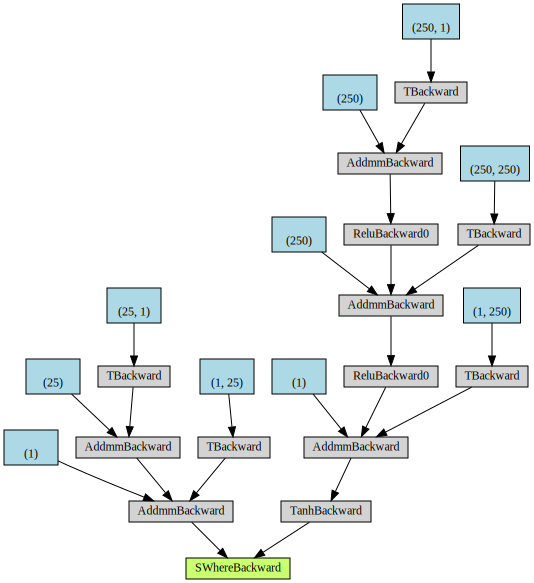

In [52]:
_, out_tensor = agent.predict(np.array([[1]], dtype=np.float32), return_tensor=True)
make_dot(out_tensor)